In [1]:
%matplotlib inline

In [2]:
# Reguired libraries
import os
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.basemap import cm
import seaborn as sns
from collections import OrderedDict
from netCDF4 import num2date
from scipy.stats import pearsonr
from datetime import datetime
from calendar import month_abbr, month_name

# For temporary display of existing figures
from IPython.display import Image

# RASM lib plotting utilities
from rasmlib.calendar import dpm
from rasmlib.analysis.climatology import season_mean, annual_mean, get_dpm
from rasmlib.analysis.plotting import cmap_discretize, sub_plot_pcolor, projections, default_map, make_bmap, seasons

# Set some general plotting values
fontsize = 7
dpi = 200 # set to 900 for final publication
mpl.rc('font', family='sans-serif') 
mpl.rc('font', serif='Myriad Pro') 
mpl.rc('text', usetex='false') 
mpl.rcParams.update({'font.size': fontsize})
mpl.rcParams['mathtext.default'] = 'sf'
mpl.rcParams['pdf.fonttype'] = 42


In [3]:
def rmse(s, o):
    """
    Root Mean Squared Error
    input:
        s: simulated
        o: observed
    output:
        rmses: root mean squared error
    """
    return np.sqrt(np.mean((s-o)**2))

def mae(s, o):
    """
    Mean Absolute Error
    input:
        s: simulated
        o: observed
    output:
        maes: mean absolute error
    """
    return np.mean(abs(s-o))

def bias(s, o):
    """
    Bias
    input:
        s: simulated
        o: observed
    output:
        bias: bias
    """
    return np.mean(s-o)

def nash_sutcliffe(s, o):
    """
    Nash Sutcliffe efficiency coefficient
    input:
        s: simulated
        o: observed
    output:
        ns: Nash Sutcliffe efficient coefficient
    """
    return 1 - sum((s-o)**2)/sum((o-np.mean(o))**2)

In [4]:
ncfiles = {}
# Grid and domain files
ncfiles['rasm_domain'] = '/raid2/jhamman/projects/RASM/data/inputdata/CESM/share/domains/domain.lnd.wr50a_ar9v4.100920.nc'
ncfiles['rasm_masks'] = '/raid2/jhamman/projects/RASM/data/inputdata/RASM_VICRVIC_GRID_MASKS_AND_METRICS.nc'

# RVIC param file for R-ArcticNET
ncfiles['rvic_param_rarcticnet'] = '/raid2/jhamman/projects/RASM/data/RVIC/r-arcticnet-1.0.1a/params/r-arcticnet-1.0.1a.rvic.prm.wr50a.20141105.nc'

# RASM run files used in this analysis
ncfiles['rasm_era_monthly_ts'] = '/raid2/jhamman/projects/RASM/data/processed/R1003RBRcaaa01a/lnd/monthly_mean_timeseries/R1003RBRcaaa01a.vic.hmm.197909-201312.nc'
ncfiles['rasm_cfsr_monthly_ts'] = '/raid2/jhamman/projects/RASM/data/processed/R1003RBRcaaa01b/lnd/monthly_mean_timeseries/R1003RBRcaaa01b.vic.hmm.197909-200912.nc'
ncfiles['rasm_offline_monthly_ts'] = '/raid2/jhamman/projects/RASM/data/processed/R1003RIRbaaa01e/lnd/monthly_mean_timeseries/R1003RIRbaaa01e.vic.hmm.197909-200801.nc'

# RVIC routed rasm streamflows
ncfiles['rasm_era_daily_q_ts'] = '/raid2/jhamman/projects/RASM/data/processed/R1003RBRcaaa01a/rof/rvic_offline/R1003RBRcaaa01a.rvic.h0i.19790901-2001331.nc'
ncfiles['rasm_cfsr_daily_q_ts'] = '/raid2/jhamman/projects/RASM/data/processed/R1003RBRcaaa01b/rof/rvic_offline/R1003RBRcaaa01b.rvic.h0i.19790901-20091231.nc'
ncfiles['rasm_offline_daily_q_ts'] = '/raid2/jhamman/projects/RASM/data/processed/R1003RIRbaaa01e/rof/R1003RIRbaaa01e.rvic.h0i.19790901-20080228.nc'

# Comparison datasets

# Spatio-temporal - monthly
ncfiles['era_monthly_ts1'] = '/raid2/jhamman/projects/RASM/data/compare/era-interim/wrf-197909-201212.era_i.nc'
ncfiles['era_monthly_ts2'] = '/raid2/jhamman/projects/RASM/data/compare/era-interim/met_em-197909-201212.nc'
ncfiles['era_monthly_ts3'] = '/raid2/jhamman/projects/RASM/data/compare/era-interim/era_water_vars.1979-2014.nc'
ncfiles['merra_monthly_ts'] = '/raid2/jhamman/projects/RASM/data/compare/MERRA/monthly/MERRA.prod.assim.tavgM_2d_lnd_Nx.197901-201312.SUB.wr50a.nc'
ncfiles['sheffield_monthly_ts'] = '/raid2/jhamman/projects/RASM/data/compare/sheffield2006/sheffield2006_wr50a.mm.nc'
ncfiles['adam_monthly_ts'] = '/raid2/jhamman/projects/RASM/data/compare/adam2003/adam2003_wr50a.mm.nc'

# Timeseries - monthly
rarcticnet_monthly_ts_file = "/raid2/jhamman/projects/RASM/data/compare/r-arcticnet/Discharge_ms.csv"
rarcticnet_attrs_file = "/raid2/jhamman/projects/RASM/data/compare/r-arcticnet/SiteAttributes_filled_cleaned.csv"

In [5]:
ncdata = {}
for k, v in ncfiles.items():
    try:
        print(k)
        if k != 'rvic_param_rarcticnet':
            ncdata[k] = xr.open_dataset(v)
        else:
            ncdata[k] = xr.open_dataset(v, decode_times=False)
    except:
        print(k, '<---unable to decode time!', v)
        ncdata[k] = xr.open_dataset(v, decode_times=False)

# Rename variables in datasets as necessary
name_dicts = {'era_monthly_ts1': {'rsus': 'Swup',
                                  'rsds': 'Swin',
                                  'rlus': 'Lwup',
                                  'rlds': 'Lwin',
                                  'hfss': 'Senht',
                                  'hfls': 'Latht',
                                  'snow_depth': 'Swq',
                                  'precip_tot': 'Precipitation',
                                  'LW_deac_net': 'Lwnet',
                                  'SW_deac_net': 'Swnet',
                                  'west_east': 'x',
                                  'south_north': 'y'},
              'era_monthly_ts2': {'T_2m': 'Tair',
                                  'west_east': 'x',
                                  'south_north': 'y'},
              'era_monthly_ts3': {'tp': 'Precipitation',
                                  'e': 'Evap',
                                  'ro': 'Runoff'},
              'sheffield_monthly_ts':{'tas': 'Tair',
                                      'prcp': 'Precipitation'},
              'merra_monthly_ts': {'prectot': 'Precipitation',
                                   'runoff': 'Runoff',
                                   'baseflow': 'Baseflow',
                                   'shland': 'Senht',
                                   'lhland': 'Latht',
                                   'snomas': 'Swq',
                                   'evland': 'Evap',
                                   'lwland': 'Lwnet',
                                   'swland': 'Swnet',
                                   },
              'merra_daily_ts': {'snomas': 'Swq'},
              'cru_monthly_ts': {'tmp': 'Tair',
                                 'pre': 'Precipitation'},
              'adam_monthly_ts': {'Precip': 'Precipitation'},
              'gfluxnet_monthly_ts': {'EnsembleHcor_May12': 'Senht',
                                      'EnsembleLEcor_May12': 'Latht'},
              'globalbedo_monthly_ts': {'albedo': 'calc_albedo'}
              }

for k, v in ncdata.items():
    if k in name_dicts:
        print(k)
        v.rename(name_dicts[k], inplace=True)

merra_monthly_ts
rasm_masks
rvic_param_rarcticnet
rasm_cfsr_monthly_ts
rasm_offline_monthly_ts
adam_monthly_ts
rasm_era_daily_q_ts
era_monthly_ts1
rasm_domain
rasm_era_monthly_ts
era_monthly_ts2
rasm_offline_daily_q_ts
rasm_cfsr_daily_q_ts
era_monthly_ts3
sheffield_monthly_ts
merra_monthly_ts
adam_monthly_ts
era_monthly_ts1
era_monthly_ts2
era_monthly_ts3
sheffield_monthly_ts


In [6]:
# time series from R-arcticNET
ocean_basin_runoff = pd.read_table('http://www.r-arcticnet.sr.unh.edu/v4.0/TallinnPaper/TallinnPaperData.txt', skiprows=11)
ocean_basin_runoff.index = pd.date_range(start='{0:d}-01-01'.format(int(ocean_basin_runoff['Year'][0])), freq='AS', periods=len(ocean_basin_runoff))
del ocean_basin_runoff['Year']

In [7]:
ncdata['rasm_offline_monthly_ts'] = ncdata['rasm_offline_monthly_ts'].sel(time=slice('1979-09-01', '2007-12-31'))

In [8]:
re = 6.37122e6
# Add variables or adjust units of datasets if ncessary

# RASM
ncdata['rasm_domain']['area'] *= re * re  # m2
for r in ['rasm_era_monthly_ts', 'rasm_cfsr_monthly_ts', 'rasm_offline_monthly_ts']:
    ncdata[r]['runoff_tot'] = ncdata[r]['Runoff'] + ncdata[r]['Baseflow']
    ncdata[r]['p-q'] = ncdata[r]['Precipitation'] - ncdata[r]['runoff_tot']
    ncdata[r]['q/p'] = ncdata[r]['runoff_tot'] / ncdata[r]['Precipitation']

# sheffield
ncdata['sheffield_monthly_ts']['Tair'] -= 273.15
ncdata['sheffield_monthly_ts']['Precipitation'] *= 86400 

# ERA-Interim
for var in ('Runoff', 'Precipitation', 'Evap'):
    ncdata['era_monthly_ts3'][var] *= 1000
ncdata['era_monthly_ts3'] = ncdata['era_monthly_ts3'].resample('MS', how='mean', dim='time')
ncdata['era_monthly_ts3']['runoff_tot'] = ncdata['era_monthly_ts3']['Runoff']

# MERRA
ncdata['merra_monthly_ts']['Precipitation'] *= 86400 
ncdata['merra_monthly_ts']['Runoff'] *= 86400 
ncdata['merra_monthly_ts']['Baseflow'] *= 86400 
ncdata['merra_monthly_ts']['Evap'] *= 86400 
ncdata['merra_monthly_ts']['runoff_tot'] = ncdata['merra_monthly_ts']['Runoff'] + ncdata['merra_monthly_ts']['Baseflow']
ncdata['merra_monthly_ts']['p-q'] = ncdata['merra_monthly_ts']['Precipitation'] - ncdata['merra_monthly_ts']['runoff_tot']
ncdata['merra_monthly_ts']['q/p'] = ncdata['merra_monthly_ts']['runoff_tot'] / ncdata['merra_monthly_ts']['Precipitation']

In [9]:
# create a new precipitation variable that is mostly adam but uses merra to fill nans around the edges
islice = slice('1980-01-01', '2007-10-01')

ncdata['merra_monthly_ts'].load()
inds = ncdata['merra_monthly_ts']['time'].argsort()
ncdata['merra_monthly_ts'] = ncdata['merra_monthly_ts'].isel(time=inds).sel(time=islice)

p = ncdata['merra_monthly_ts']['Precipitation']
ncdata['adam_monthly_ts']['time'] = pd.date_range('1948-01-01', freq='MS',
                                                  periods=len(ncdata['adam_monthly_ts'].indexes['time']))
obs_p = ncdata['adam_monthly_ts']['Precipitation'].sel(time=islice)

inds = np.isfinite(obs_p.values)

p.values[inds] = obs_p.values[inds]

ncdata['obs'] = {'Precipitation': p}

In [10]:
# Local functions 
def percent_error(approx, exact):
    return abs(approx-exact)/abs(exact)

def masks_from_rvic_param(rvic_param, domain):

    basin_masks = OrderedDict()
    
    for outlet, name in zip(rvic_param['outlet_number'].values,
                            rvic_param['outlet_name'].values):
        inds = rvic_param['source2outlet_ind'].values == outlet
        ys = rvic_param['source_y_ind'].values[inds]
        xs = rvic_param['source_x_ind'].values[inds]

        oy = rvic_param['outlet_y_ind'].values[outlet]
        ox = rvic_param['outlet_x_ind'].values[outlet]

        source_area = domain['area'].values[ys, xs]
        outlet_area = domain['area'].values[oy, ox]

        scale_factors = outlet_area / source_area

        basin_masks[name] = np.zeros_like(domain['mask'], dtype=np.float)
        basin_masks[name][ys, xs] = rvic_param['unit_hydrograph'].values[:, inds, 0].sum(axis=0) * scale_factors
        
    return basin_masks


def read_r_arctic_net_data(data_file, attrs_file):
    '''read R-ArcticNET dataset into Pandas.DataFrame
    
    return data, drainage_area, attributes
    '''
    def make_dates(years):
        dates = []
        for year in years:
            for month in range(1,13):
                dates.append(datetime(year, month, 1))
        return dates

    # open attributes file
    atts = pd.read_csv(attrs_file, engine='python')

    # open observations file(s)
    data = pd.read_csv(data_file, low_memory=False)

    # Flatten monthly structure
    _r_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    data_series = {}
    basin_area = {}
    for i, point in enumerate(atts['PointID']):
        name = atts['Name'][i].replace("'", '').replace(" ", "_").encode()

        inds = np.nonzero(data['Point_ID']==point)[0]
        flow_table = np.empty((len(inds), len(_r_months)))

        for j, month in enumerate(_r_months):
            flow_table[:,j] = data[month][inds]

        times = make_dates(data['Year'][inds])

        da = atts['DArea_effective'][i] * 1000. * 1000. # m2

        flows = flow_table.flatten() / da * 1000 * 86400  # mm/d
        basin_area[name] = da
        data_series[name] = pd.Series(flows, index=times)

    observations = pd.DataFrame(data_series)
    
    observations[observations <= 0] = np.nan
    
    return observations, basin_area, atts


def annual_mean_from_monthly_means(df, calendar='standard'):

    month_length = pd.Series(get_dpm(df.index), index=df.index)
    years = np.asarray([polar_water_year(x) for x in df.index])
    dpy = month_length.groupby(polar_water_year).sum()
    weights = np.zeros_like(month_length, dtype=np.float)
    for i, year in enumerate(years):
        weights[i] = month_length[i] / dpy[dpy.index==year].values[0]
    weights = pd.Series(weights, index=month_length.index)

    # Using numpy.sum handles will return nans when not all portions of the group are not nans
    return(df * weights).resample('AS', how=lambda x: x.values.sum()).dropna(how='all')

def polar_water_year(x):
    if x.month < 9:
        return x.year
    else:
        return x.year + 1

In [11]:
# make masks dict for all r-ArcticNET stations
rvic_masks = masks_from_rvic_param(ncdata['rvic_param_rarcticnet'], ncdata['rasm_domain'])
rvic_source_areas = OrderedDict()

for k, mask in rvic_masks.items():
    rvic_source_areas[k] = (ncdata['rasm_domain']['area'].values * mask).sum()

In [12]:
# Read R-ArcticNET data
obs_monthly_data, obs_drainage_area, obs_attrs = read_r_arctic_net_data(rarcticnet_monthly_ts_file, rarcticnet_attrs_file)

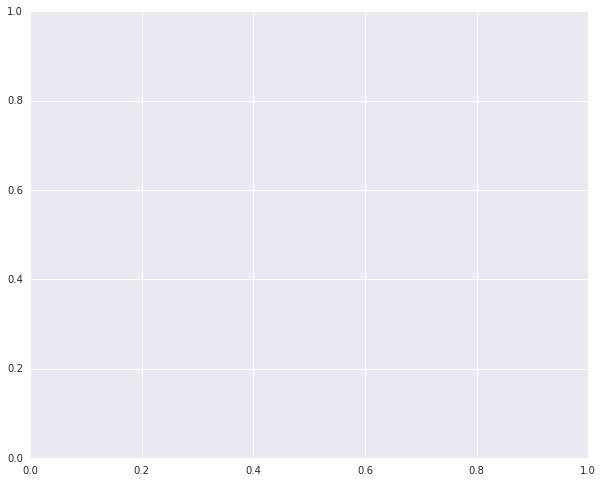

In [13]:
fig, ax = plt.subplots(figsize=(10, 8))
df = obs_monthly_data['1942-01-01':'2010-01-01'].groupby(lambda x: x.date).count()
# df.sum(axis=1).plot(fontsize=14)
# plt.ylabel('Observations/Month', fontsize=14)
# plt.title('R-ArcticNet', fontsize=16)
# plt.savefig('r-arcticnet_coverage.png', dpi=250)
# plt.close()

In [14]:
obs_monthly_data = obs_monthly_data['1980-01-01':'2014-12-31']

In [15]:
# Select masks with drainage_area that is close to the reported value in R-ArcticNET
pe_thresh = 0.10
drop_names = []
keep_names = []
for k, v in obs_drainage_area.items():
    try:
        pe = percent_error(rvic_source_areas[k], v)
        if pe < pe_thresh and v > 0.:
            keep_names.append(k)
        else:
            drop_names.append(k)
    except KeyError:
        pass
print('kept', len(keep_names), 'stations')

for drop_key in drop_names:
    rvic_source_areas.pop(drop_key, None)
    obs_drainage_area.pop(drop_key, None)
    rvic_masks.pop(drop_key, None)
    try:
        del obs_monthly_data[drop_key]
    except KeyError:
        pass
print('dropped', len(drop_names), 'stations')

kept 451 stations
dropped 1283 stations


In [16]:
obs_annual_data = annual_mean_from_monthly_means(obs_monthly_data.resample('MS')['1980-01-01':'2014-12-31'].dropna(how='all'))

In [17]:
def get_rasm_basin_data(variables, sources, calendars, masks=rvic_masks, names=keep_names):
    var_data = {}
    var_data_annual = {}
    for var in variables:
        var_data[var] = {}
        var_data_annual[var] = {}
        for source, calendar in zip(sources, calendars):
            s = {}
            dss = ncdata[source][var].sel(time=slice('1980-01-01', obs_monthly_data.index[-1]))
            for k in names:
                ys, xs = np.nonzero(masks[k])
                s[k] = pd.Series((dss.values[:, ys, xs] *
                                  ncdata['rasm_domain']['area'].values[ys, xs] *
                                  masks[k][ys, xs]).sum(axis=1),
                                 index=dss.indexes['time']).resample('MS')
                s[k] /= rvic_source_areas[k]
            var_data[var][source] = pd.DataFrame(s)
            var_data_annual[var][source] = annual_mean_from_monthly_means(var_data[var][source],
                                                                               calendar=calendar)
            
    return var_data, var_data_annual

In [18]:
mod_data, mod_data_annual = get_rasm_basin_data(['runoff_tot', 'Precipitation'],
                                                ['rasm_era_monthly_ts', 'rasm_cfsr_monthly_ts', 'rasm_offline_monthly_ts', 'merra_monthly_ts', 'era_monthly_ts3'],
                                                ['noleap', 'noleap', 'noleap', 'standard', 'standard'])

In [19]:
pobs_data, pobs_data_annual = get_rasm_basin_data(['Precipitation'],
                                                  ['obs'],
                                                  ['standard'])

In [20]:
# transform structure:
# --dataset
# ----station
# ------vars

# obs
obs_stations = {}
for station in keep_names:
    data = {}
    data['q'] = obs_annual_data[station]
    data['p'] = pobs_data_annual['Precipitation']['obs'][station]
    
    df = pd.DataFrame(data)
    
    df['p-q'] = df['p'] - df['q']
    df['p-q/p'] = (df['p'] - df['q']) / df['p']
    df['q/p'] = df['q'] / df['p']
    
    obs_stations[station] = df


In [21]:
# transform structure:
# --dataset
# ----station
# ------vars
mod_stations = {}
for mod in ['rasm_era_monthly_ts', 'rasm_cfsr_monthly_ts', 'rasm_offline_monthly_ts', 'merra_monthly_ts', 'era_monthly_ts3']:
    mod_stations[mod] = {}
    for station in keep_names:
        data = {}
        data['q'] = mod_data_annual['runoff_tot'][mod][station]
        data['p'] = mod_data_annual['Precipitation'][mod][station]

        df = pd.DataFrame(data)

        df['p-q'] = df['p'] - df['q']
        df['p-q/p'] = (df['p'] - df['q']) / df['p']
        df['q/p'] = df['q'] / df['p']
        

        mod_stations[mod][station] = df

In [22]:
def get_scatter_data(obs, mod, names):
    '''structure for plotting single dataset vs observations:
    --variable (dict)
    ----datasets (df)'''


    variables = {}
    
    for v in ['q', 'p', 'p-q', 'q/p', 'p-q/p']:
        xs = []
        ys = []    
        for k in names:
            null = obs[k]['q'].isnull()  # use streamflow to determine which years to drop

            df = pd.DataFrame({'obs': obs[k][v][~null],
                               'mod': mod[k][v][~null]}).dropna().mean()
            ys.append(df['mod'])
            xs.append(df['obs'])
        
        variables[v] = pd.DataFrame({'obs': xs, 'mod': ys}).dropna()
        
    return variables 

0 basins used in this plot


/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


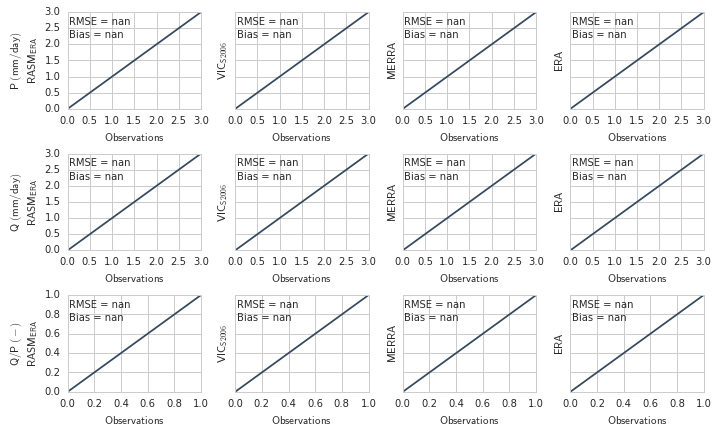

In [23]:
sns.set_style("whitegrid")

varnames = ['p', 'q', 'q/p']
var_labels = ['$P\ (mm/day)$', '$Q\ (mm/day)$', '$Q/P\ (-)$', '$(P-Q)/P\ (-)$']
# mod_labels = ['$RASM_{ERA}$', '$RASM_{CFSR}$', '$VIC_{SHEFFIELD}$', '$MERRA$', '$ERA$']
mod_labels = ['$RASM_{ERA}$', '$VIC_{S2006}$', '$MERRA$', '$ERA$']
lims = [(0, 3), (0, 3), (0, 1), (0, 1)]

datanames = ['rasm_era_monthly_ts', 'rasm_cfsr_monthly_ts', 'rasm_offline_monthly_ts', 'merra_monthly_ts', 'era_monthly_ts3']
datanames = ['rasm_era_monthly_ts', 'rasm_offline_monthly_ts', 'merra_monthly_ts', 'era_monthly_ts3']

fig, axes = plt.subplots(nrows=len(varnames), ncols=len(datanames), sharey='row', figsize=(10, 6))

for j, mod in enumerate(datanames):

    variables = get_scatter_data(obs_stations, mod_stations[mod], keep_names)
    
    for i, var in enumerate(varnames):
        ax = axes[i, j]
        plt.sca(ax)
        
        sns.regplot('obs', 'mod', data=variables[var], ax=ax, lowess=True, marker='.',
                    color='#95a5a6', line_kws={'color': sns.xkcd_rgb["denim blue"]},
                    truncate=True)
        ax.plot(lims[i], lims[i], color='#34495e')
#         temp = nash_sutcliffe(variables[var]['mod'], variables[var]['obs'])
#         ax.annotate("Nash = {0:0.2}".format(temp), (lims[i][1] * 0.01, lims[i][1] * 0.9), fontsize=10)
        temp = rmse(variables[var]['mod'], variables[var]['obs'])
        ax.annotate("RMSE = {0:0.2}".format(temp), (lims[i][1] * 0.01, lims[i][1] * 0.87), fontsize=10)
        temp = bias(variables[var]['mod'], variables[var]['obs'])
        ax.annotate("Bias = {0:0.2}".format(temp), (lims[i][1] * 0.01, lims[i][1] * 0.73), fontsize=10)
        if j == 0:
            yl = '{0}\n{1}'.format(var_labels[i], mod_labels[j])
        else:
            yl = mod_labels[j]
        ax.set_ylabel(yl)
        ax.set_xlabel('$Observations$')
        
        ax.set_ylim(lims[i])
        ax.set_xlim(lims[i])
plt.tight_layout()
print(len(variables[var]['mod']), 'basins used in this plot')

# plt.savefig('pan-arctic-scatter-lowess.png', dpi=dpi, bbox_inches='tight')
fig.savefig(os.path.join(os.environ['FTP'], 'RASM_land_surface_climate_figures', 'Figure_12.pdf'), dpi=dpi, bbox_inches='tight')

0 basins used in this plot


/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


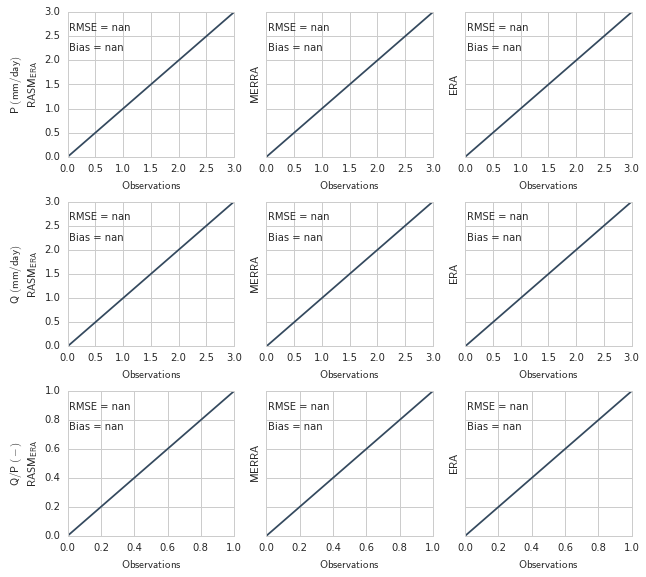

In [24]:
sns.set_style("whitegrid")

varnames = ['p', 'q', 'q/p']
var_labels = ['$P\ (mm/day)$', '$Q\ (mm/day)$', '$Q/P\ (-)$', '$(P-Q)/P\ (-)$']
# mod_labels = ['$RASM_{ERA}$', '$RASM_{CFSR}$', '$VIC_{SHEFFIELD}$', '$MERRA$', '$ERA$']
mod_labels = ['$RASM_{ERA}$', '$MERRA$', '$ERA$']
lims = [(0, 3), (0, 3), (0, 1), (0, 1)]

datanames = ['rasm_era_monthly_ts', 'merra_monthly_ts', 'era_monthly_ts3']

fig, axes = plt.subplots(nrows=len(varnames), ncols=len(datanames), sharey='row', figsize=(9, 8))

for j, mod in enumerate(datanames):

    variables = get_scatter_data(obs_stations, mod_stations[mod], keep_names)
    
    for i, var in enumerate(varnames):
        ax = axes[i, j]
        plt.sca(ax)
        
        sns.regplot('obs', 'mod', data=variables[var], ax=ax, lowess=True, marker='.',
                    color='#95a5a6', line_kws={'color': sns.xkcd_rgb["denim blue"]},
                    truncate=True)
        ax.plot(lims[i], lims[i], color='#34495e')
#         temp = nash_sutcliffe(variables[var]['mod'], variables[var]['obs'])
#         ax.annotate("Nash = {0:0.2}".format(temp), (lims[i][1] * 0.01, lims[i][1] * 0.9), fontsize=10)
        temp = rmse(variables[var]['mod'], variables[var]['obs'])
        ax.annotate("RMSE = {0:0.2}".format(temp), (lims[i][1] * 0.01, lims[i][1] * 0.87), fontsize=10)
        temp = bias(variables[var]['mod'], variables[var]['obs'])
        ax.annotate("Bias = {0:0.2}".format(temp), (lims[i][1] * 0.01, lims[i][1] * 0.73), fontsize=10)
        if j == 0:
            yl = '{0}\n{1}'.format(var_labels[i], mod_labels[j])
        else:
            yl = mod_labels[j]
        ax.set_ylabel(yl)
        ax.set_xlabel('$Observations$')
        
        ax.set_ylim(lims[i])
        ax.set_xlim(lims[i])
plt.tight_layout()
print(len(variables[var]['mod']), 'basins used in this plot')

plt.savefig('pan-arctic-scatter-lowess_presentation.png', dpi=dpi, bbox_inches='tight')

In [25]:
names = list(map(bytes.decode, keep_names))
to_save = obs_attrs.copy()
inds = []
for i, name in enumerate(obs_attrs['Name'].values):
    if name.replace("'", '').replace(" ", "_").encode() in keep_names:
        inds.append(i)

to_save = to_save.ix[inds]
to_save.to_pickle('r-arctic_attrs.pkl')